In [1]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns 
import DateTime
import re 
import cpi
import warnings
import weightedcalcs as wc

warnings.filterwarnings('ignore')

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

#### Load in PUMS household Data

got data below from downloading these zips like below
for i in range_list:
    print("https://www2.census.gov/programs-surveys/acs/data/pums/"+i+"/1-Year/csv_hca.zip")

In [2]:
#PUMA - County Crosswalk - https://mcdc.missouri.edu/applications/geocorr2018.html.
#note, manually changed all one to many (PUMA->County) matchings to just be "Multiple CA".
#These are the small counties that are just a part of a PUMA and for the purpose of our analysis are combined 
crosswalk_df=pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")

In [3]:
def read_in_PUMS(hpums_df):
    variable_types = {"NP":"int64","NOC":"float","BDSP":"float","RMSP":"str","MV":"float","WGTP":"float"}

    columns = ["SERIALNO","NP","R65","NRC","PUMA","RT","BDSP","BLD","RNTP","MRGP","SMP", "TYPE",
               "CONP","TEN","VACS","VALP","GRPIP","GRNTP","SMOCP","OCPIP","HINCP","MV","WGTP","NOC", "MULTG", 'YBL']


    hpums_df.rename(columns={"RT":"record_type",
                         "TYPE":"type",
                         "BLD":"units_in_structure",
                         "BDSP":"number_bedrooms",
                         "RNTP":"monthly_rent",
                         "MRGP":"first_mortgage",
                         "SMP":"second_mortgage",
                         "CONP":"condo_fee",
                         "TEN":"tenure",
                         "VACS":"vacancy_status",
                         "VALP":"property_value",
                         "GRPIP":"gross_rent_pct_of_income",
                         "GRNTP":"gross_rent",
                         "SMOCP":"select_owner_cost",
                         "OCPIP":"select_owner_cost_pct_of_income",
                         "HINCP":"hh_income",
                         "NP":"ppl_in_hh",
                         "R65":"ppl_over_65",
                         "NRC":"num_relate_chldrn",
                         "NOC":"num_own_chldrn",
                         "MULTG":"multi_gen_hh",
                         "WGTP":"weight",
                         "YBL": "year_built",
                         "MV":"moved_in"}, inplace=True)
    hpums_df.drop(hpums_df[hpums_df.type != 1].index, inplace=True)
    
    return hpums_df

In [4]:
#pums2.to_csv("2010-2019_ca_household_survey_v2.csv")

Put this code in this cell because I want to be rerunning file and easier to just load in output of below from a csv then wait for the below to run to run everytime. But this code takes the 2010-2019 PUMS household data, makes a year column, and then concat its together 

for filename in os.listdir(path_csv):
    df_new1 = pd.read_csv(os.path.join(path_csv, filename))
    df_new1= read_in_PUMS(df_new1,col_names)
    df_new1["year"] = filename[-8:-4] 
    hca = pd.concat([hca,df_new1],ignore_index=True)
pums_ca = hca.ST["6"]#added retroactively 

In [5]:
#load in output of above from CSV 
pums_ca_raw = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/2010-2019_ca_household_survey_v2.csv")
pums_sub_cols = ['year',"hh_income","ppl_in_hh",'PUMA',"gross_rent","monthly_rent","weight"]#Took more cols just in case from big dataset above, but this is all we need for this calc #took county col out here to recreate later 
pums_ca_raw = pums_ca_raw[pums_sub_cols]

### Do PUMA to County Crosswalk

Note: for years 2010 and 2011 the 2010 PUMA defintions were still being used; it was not until 2012 that the
    new definitions came into effect. Therefore need to map the 2010-2011 and 2012-2019 groups seperately. 

merge other crosswalk file on here and drop PUMA10_Name
then drop duplicates 
should preprocess this to be just mapping of puma00 to unique county 

analysitics gut check, are top 10 counties the correct top 10 counties 

In [6]:
def map2counties(pums_ca):
    crosswalk_df2010 = pd.read_excel("PUMA2000_PUMA2010_crosswalk.xls") # https://usa.ipums.org/usa/volii/pumas10.shtml#crosswalk
    crosswalk_df2010 = crosswalk_df2010[crosswalk_df2010.State10_Name =="California"]
    crosswalk_df2010 = crosswalk_df2010[["PUMA00","PUMA10","PUMA10_Name"]] 
    crosswalk_df2012 = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")
    crosswalk_df2010 = crosswalk_df2010.merge(crosswalk_df2012,left_on="PUMA10",right_on="PUMA", how='left')#[["PUMA00","county1"]]
    crosswalk_df2010 = crosswalk_df2010.drop_duplicates(subset=["PUMA00"])
    
    df_2010 = pums_ca[pums_ca.year.isin([2010,2011])] 
    df_2010 = pd.merge(df_2010, crosswalk_df2010, left_on='PUMA', right_on='PUMA00', how='left')
    
    df_2012 = pums_ca[~pums_ca.year.isin([2010,2011])]
    df_2012 = pd.merge(df_2012, crosswalk_df2012, on='PUMA', how='left')
    
    df = df_2010.append(df_2012)
    df['County'] = df['county1'].str.replace(r' CA', '')
    df.loc[df.PUMA_x.notnull(), 'PUMA'] = df.loc[df.PUMA_x.notnull(), 'PUMA_x'] 
    return df[['year', 'hh_income', 'ppl_in_hh', 'gross_rent', 'PUMA', 'County',"monthly_rent","weight"]]
    

In [7]:
pums_ca = map2counties(pums_ca_raw)

In [8]:
#missing shasta and modera in 2010-2011, they are now mapped to multiple, this is a quirk of the mappings change and they are not in top 10 msa so its fine 
pums_ca.groupby(["year","County"]).count().reset_index().groupby("year").count()

,County,hh_income,ppl_in_hh,gross_rent,PUMA,monthly_rent,weight
year,,,,,,,
2010,34,34,34,34,34,34,34
2011,34,34,34,34,34,34,34
2012,36,36,36,36,36,36,36
2013,36,36,36,36,36,36,36
2014,36,36,36,36,36,36,36
2015,36,36,36,36,36,36,36
2016,36,36,36,36,36,36,36
2017,36,36,36,36,36,36,36
2018,36,36,36,36,36,36,36


In [9]:
pums_ca = pums_ca[(pums_ca.hh_income != ' ')] # we lose ~8k records for missing data
pums_ca['hh_income'] = pums_ca.hh_income.astype(float)
pums_ca['ppl_in_hh'] = pums_ca.ppl_in_hh.astype(float)

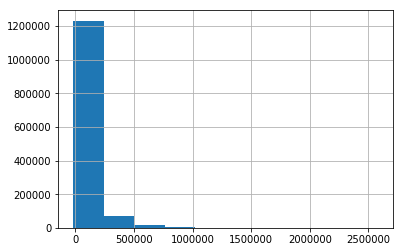

In [10]:
import matplotlib.pyplot as plt
#check for outliers in hh income 
pums_ca.hh_income.hist()

In [11]:
#in this dataset negative income doenst really make sense, so I'll drop those rows.
#Strange to see renter with 2.5 million income, but certainly not impossible in california so can't
#assume data error. 
pums_ca.hh_income.describe()

count   1316531.00
mean      95826.00
std      104647.27
min      -15700.00
25%       32300.00
50%       67000.00
75%      120500.00
max     2580000.00
Name: hh_income, dtype: float64

In [12]:
pums_ca = pums_ca[pums_ca['hh_income'] >=0] #drop negative hh income  

In [13]:
pums_ca.County = pums_ca.County.str.rstrip()#strip trailing white space 
pums_ca = pums_ca.replace({
    'County':{'Monterey (South & East) & San Benito Countie':"Multiple",
            'Nevada & Sierra Countie':"Multiple","Sutter & Yuba Counties--Yuba Cit":"Multiple",
            "Del Norte, Lassen, Modoc, Plumas & Siskiyou Countie":"Multiple",
            "Alpine, Amador, Calaveras, Inyo, Mariposa, Mono & Tuolumne Countie":"Multiple",
             'Colusa, Glenn, Tehama & Trinity Countie':"Multiple",
             "Lake & Mendocino Countie":"Multiple"}})#the 2010-2011 data did the one to many PUMA to County mapping, I'm just manually setting these to the Multiple category

There is going to be a discrepency between the HUD data, which has every county in California, 
with the PUMS data, which has only the those that have a least one PUMA soley mapped to it. 
We need then to map the small counties in HUD with a one PUMA to many counties matching to the 
"multiple counties" category that we have in the PUMS data. 

### Merge HUD and PUMS data 

In [14]:
# read in HUD AMI data downloaded for each year from here https://www.huduser.gov/portal/datasets/il.html#2010
path = "/Users/quinnunderriner/Desktop/Work/missing_middle/county_median_data/"
#path = os.getcwd()
df = pd.DataFrame()
for filename in os.listdir(path):
    if filename.startswith("HUD-IL"):
        df_new = pd.read_csv(os.path.join(path, filename))
        df_new["year"] = filename[-8:-4]
        median_col = [x for x in df_new.columns if "median" in x]

        df_new = df_new.rename(columns={median_col[0]:"median"})

        columns = ["State_Alpha","County_Name","Metro_Area_Name","year","median"]
        df_new = df_new[columns]
        df = pd.concat([df,df_new],ignore_index=True)
df = df[df.State_Alpha =="CA"]#filter for california
#df.to_csv("california_hud_AMI_levels_2010-2019.csv")

In [15]:
#df is loaded at top of notebook, is HUD data 
#make sets of both county lists and look at the set difference to see what needs the "multiple" mapping 
pums_ca['County_Name'] = pums_ca.County + " County"#make naming conventions align with HUD data so can merge

pums_set = set(pums_ca.County_Name)
hud_set = set(df["County_Name"])#now want to map everything not present in this data to the multiple category 
small_counties = hud_set.difference(pums_set) #using set difference easily allows us to see what is in HUD but not in PUMS

In [16]:
def small_multiples(x):
    """
    This function returns "Multiple Counties" if county name is in the list of small counties, otherwise
    keeps same value 
    """
    if x in small_counties:
        return "Multiple County"
    else:
        return x 
df["County_Name"] = df["County_Name"].apply(lambda x: small_multiples(x))

df.year = df.year.astype(int)#to be able to merge 
df.loc[df.County_Name=='Multiple County', 'Metro_Area_Name'] = 'Multiple'

df = df.groupby(['year', 'County_Name', 'Metro_Area_Name'])['median'].median().reset_index() # take median of multiple counties

In [17]:
#merge data 
df_merged = pums_ca.merge(df,on=["County_Name","year"],how="left")
#df_merged.to_csv("HUD_PUMS_merged_data_CA.csv")

In [18]:
df_merged.groupby('year').count()

,hh_income,ppl_in_hh,gross_rent,PUMA,County,monthly_rent,weight,County_Name,Metro_Area_Name,median
year,,,,,,,,,,
2010,128552,128552,48131,128552,128552,48131,128552,128552,128552,128552
2011,128957,128957,48907,128957,128957,48907,128957,128957,128957,128957
2012,129197,129197,49844,129197,129197,49844,129197,129197,129197,129197
2013,130078,130078,50354,130078,130078,50354,130078,130078,130078,130078
2014,131060,131060,131060,131060,131060,131060,131060,131060,131060,131060
2015,132140,132140,51036,132140,132140,51036,132140,132140,132140,132140
2016,132754,132754,50927,132754,132754,50927,132754,132754,132754,132754
2017,133375,133375,50837,133375,133375,50837,133375,133375,133375,133375
2018,134192,134192,50884,134192,134192,50884,134192,134192,134192,134192


Need to adjust median income figure for family size 

"Calculation of income limits for other family sizes is straight-forward. The 1-person family income limit is 70% of the 4-person income limit. The 2-person family income limit is 80% of the 4-person income limit, the 3-person family income limit is 90% of the 4-person income limit, the 5-person income limit is 108% of the 4-person income limit, the 6-person family income limit is 116% of the 4-person income limit, the 7-person family income limit is 124% of the 4-person income limit, and the 8-person family income limit is 132% of the 4-person income limit. For family sizes larger than 8 persons, the income limit can be calculated by adding an additional eight (8) percent per person to the next lower limit. For example a 9-person family income limit is 140% (132% + 8%), and so on. The resulting low-income limit calculation for other family sizes are then rounded up to the nearest $50 to produce the Final VLIL."

https://www.huduser.gov/portal/datasets/il/il2020/2020IlCalc.odn


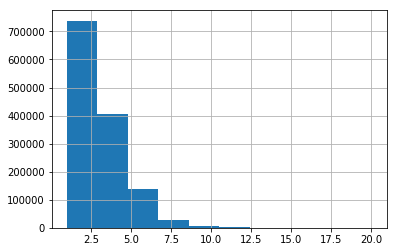

In [19]:
#need to have household adjustments for up to size 20 
df_merged.ppl_in_hh.hist()

### Create AMI bands and normalize by family size 

In [20]:
family_size_dict = {1:.7,
                   2:.8,
                   3:.9,
                   4:1,
                    5:1.08,
                    6:1.16,
                    7:1.24,
                    8:1.32,
                   9:1.40,
                   10:1.48,
                   11:1.56,
                   12:1.64,
                   13:1.72,
                   14:1.80,
                   15:1.88,
                   16:1.96,
                   17:2.04,
                   18:2.12,
                   19:2.20,
                   20:2.28}
#make new column of the AMI multiplier based on each households family size 
df_merged["family_size_multiplier"] = df_merged["ppl_in_hh"].map(family_size_dict)

In [21]:
#create AMI percentages from median numbers and adjust for size of each household 
df_merged["80%_AMI"] = df_merged["median"] * 0.8
df_merged["120%_AMI"] = df_merged["median"] * 1.2
#adjust ami bands for each household based on household size 
df_merged["80%_AMI_adjusted"] = df_merged["80%_AMI"] * df_merged["family_size_multiplier"]
df_merged["120%_AMI_adjusted"] = df_merged["120%_AMI"] * df_merged["family_size_multiplier"]

df_merged["30%_AMI"] = df_merged["median"] * 0.3
df_merged["30%_AMI_adjusted"] = df_merged["30%_AMI"] * df_merged["family_size_multiplier"]

df_merged["60%_AMI"] = df_merged["median"] * 0.6
df_merged["60%_AMI_adjusted"] = df_merged["60%_AMI"] * df_merged["family_size_multiplier"]

df_merged["100%_AMI_adjusted"] = df_merged["median"] * df_merged["family_size_multiplier"]

In [22]:
#want to create binary varables for all of the income groups 
df_merged['0-30%AMI_HH_adj'] = np.where((df_merged["hh_income"] < df_merged["30%_AMI_adjusted"]), 1, 0)

#can add 30-60 even if not on sheet 
df_merged['30-60%AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["30%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["60%_AMI_adjusted"]), 1, 0)

df_merged['60-80%_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["60%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["80%_AMI_adjusted"]), 1, 0)

df_merged['80-100%_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["100%_AMI_adjusted"]), 1, 0)

df_merged['100-120%_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["100%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["120%_AMI_adjusted"]), 1, 0)

df_merged['120%+_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["120%_AMI_adjusted"]), 1, 0)



#want to label households in dataset that are middle income 
df_merged['middle_income_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI_adjusted"])&(df_merged["hh_income"] <= df_merged["120%_AMI_adjusted"]), 1, 0)

In [23]:
#want to create binary varables for all of the income groups 
df_merged['0-30%AMI_HH'] = np.where((df_merged["hh_income"] < df_merged["30%_AMI"]), 1, 0)

#can add 30-60 even if not on sheet 
df_merged['30-60%AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["30%_AMI"])&(df_merged["hh_income"] < df_merged["60%_AMI"]), 1, 0)

df_merged['60-80%_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["60%_AMI"])&(df_merged["hh_income"] < df_merged["80%_AMI"]), 1, 0)

df_merged['80-100%_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI"])&(df_merged["hh_income"] < df_merged["median"]), 1, 0)

df_merged['100-120%_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["median"])&(df_merged["hh_income"] < df_merged["120%_AMI"]), 1, 0)

df_merged['120%+_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["120%_AMI"]), 1, 0)



#want to label households in dataset that are middle income 
df_merged['middle_income_HH'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI"])&(df_merged["hh_income"] <= df_merged["120%_AMI"]), 1, 0)

In [24]:
df_merged.head()

,year,hh_income,ppl_in_hh,gross_rent,PUMA,County,monthly_rent,weight,County_Name,Metro_Area_Name,median,family_size_multiplier,80%_AMI,120%_AMI,80%_AMI_adjusted,120%_AMI_adjusted,30%_AMI,30%_AMI_adjusted,60%_AMI,60%_AMI_adjusted,100%_AMI_adjusted,0-30%AMI_HH_adj,30-60%AMI_HH_adj,60-80%_AMI_HH_adj,80-100%_AMI_HH_adj,100-120%_AMI_HH_adj,120%+_AMI_HH_adj,middle_income_HH_adj,0-30%AMI_HH,30-60%AMI_HH,60-80%_AMI_HH,80-100%_AMI_HH,100-120%_AMI_HH,120%+_AMI_HH,middle_income_HH
0,2011,74000.00,2.00,NaN,800.00,Butte,NaN,55,Butte County,"Chico, CA MSA",57900,0.80,46320.00,69480.00,37056.00,55584.00,17370.00,13896.00,34740.00,27792.00,46320.00,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,2011,29300.00,1.00,780.0,6113.00,Los Angeles,750.0,36,Los Angeles County,"Los Angeles-Long Beach, CA HUD Metro FMR Area",64000,0.70,51200.00,76800.00,35840.00,53760.00,19200.00,13440.00,38400.00,26880.00,44800.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,2011,12600.00,2.00,1150.0,800.00,Butte,1000.0,54,Butte County,"Chico, CA MSA",57900,0.80,46320.00,69480.00,37056.00,55584.00,17370.00,13896.00,34740.00,27792.00,46320.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2011,96200.00,2.00,NaN,8004.00,Riverside,NaN,9,Riverside County,"Riverside-San Bernardino-Ontario, CA MSA",62500,0.80,50000.00,75000.00,40000.00,60000.00,18750.00,15000.00,37500.00,30000.00,50000.00,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,2011,48004.00,1.00,NaN,900.00,Yolo,NaN,72,Yolo County,"Yolo, CA HUD Metro FMR Area",75800,0.70,60640.00,90960.00,42448.00,63672.00,22740.00,15918.00,45480.00,31836.00,53060.00,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [25]:
middle_income = df_merged[df_merged['middle_income_HH'] ==1]
middle_income_adj = df_merged[df_merged['middle_income_HH_adj'] ==1]

### calculate rent burden 

In [27]:
middle_income_adj.groupby("year").count()

,hh_income,ppl_in_hh,gross_rent,PUMA,County,monthly_rent,weight,County_Name,Metro_Area_Name,median,family_size_multiplier,80%_AMI,120%_AMI,80%_AMI_adjusted,120%_AMI_adjusted,30%_AMI,30%_AMI_adjusted,60%_AMI,60%_AMI_adjusted,100%_AMI_adjusted,0-30%AMI_HH_adj,30-60%AMI_HH_adj,60-80%_AMI_HH_adj,80-100%_AMI_HH_adj,100-120%_AMI_HH_adj,120%+_AMI_HH_adj,middle_income_HH_adj,0-30%AMI_HH,30-60%AMI_HH,60-80%_AMI_HH,80-100%_AMI_HH,100-120%_AMI_HH,120%+_AMI_HH,middle_income_HH
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,23123,23123,8350,23123,23123,8350,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123,23123
2011,22808,22808,8102,22808,22808,8102,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808,22808
2012,22956,22956,8326,22956,22956,8326,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956,22956
2013,22677,22677,8673,22677,22677,8673,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677,22677
2014,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589
2015,22542,22542,9073,22542,22542,9073,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542,22542
2016,22567,22567,9304,22567,22567,9304,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567,22567
2017,22740,22740,9573,22740,22740,9573,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740,22740
2018,22914,22914,9463,22914,22914,9463,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914,22914


In [28]:
middle_income_adj.dropna(subset=["gross_rent"]).groupby("year").count()

,hh_income,ppl_in_hh,gross_rent,PUMA,County,monthly_rent,weight,County_Name,Metro_Area_Name,median,family_size_multiplier,80%_AMI,120%_AMI,80%_AMI_adjusted,120%_AMI_adjusted,30%_AMI,30%_AMI_adjusted,60%_AMI,60%_AMI_adjusted,100%_AMI_adjusted,0-30%AMI_HH_adj,30-60%AMI_HH_adj,60-80%_AMI_HH_adj,80-100%_AMI_HH_adj,100-120%_AMI_HH_adj,120%+_AMI_HH_adj,middle_income_HH_adj,0-30%AMI_HH,30-60%AMI_HH,60-80%_AMI_HH,80-100%_AMI_HH,100-120%_AMI_HH,120%+_AMI_HH,middle_income_HH
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350,8350
2011,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102,8102
2012,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326,8326
2013,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673,8673
2014,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589,22589
2015,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073,9073
2016,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304,9304
2017,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573
2018,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463,9463


In [29]:
#gross rent is missing a decent number of values Gross rent is missing a decent number of values, and weirdly there are way more values in 2014 (an order of magnitude more), 
#although if we are just looking at 2010 and 2019 this seems fine.
middle_income_adj.gross_rent.isna().sum()

125412

In [30]:
middle_income_adj = middle_income_adj.dropna(subset=["gross_rent","hh_income"])#drop nulls in gross rent and household income
middle_income_adj = middle_income_adj[(middle_income_adj.gross_rent != ' ')] #drop empty values 
middle_income_adj["Gross_rent_%_income"] = middle_income_adj["gross_rent"].astype(float)/(middle_income_adj["hh_income"]/12)#make yearly income into monthly

In [34]:
#create binary column for if people are paying over 30% of their income in rent or not
def is_rent_burdened(x):
    if x >= .3:
        return 1
    else:
        return 0
middle_income_adj["Is_Rent_Burdened"] = middle_income_adj["Gross_rent_%_income"].apply(lambda x: is_rent_burdened(x))

#### calculate weighted change by county 

In [ ]:
#make groupby object 
middle_income_adj_grouped = middle_income_adj.groupby(["County_Name","year"])
#make weight object 
calc = wc.Calculator("weight")
#weighted mean of percentage of rent burden households
weighted_county_percentile = calc.mean(middle_income_adj_grouped, "Is_Rent_Burdened").reset_index().dropna()
weighted_county_percentile_sub = weighted_county_percentile[["County_Name",2010,2019]]
#now the value of the 2019 column is the weighted percentage change between 2010 and 2019
weighted_county_percentile_sub = weighted_county_percentile_sub.set_index('County_Name').pct_change(axis='columns').reset_index()
#rename cols for chart
weighted_county_percentile_sub = weighted_county_percentile_sub.rename(columns={"County_Name":"County Name",2019:"Percent Change in Rent Burdened Households"})
#drop 2010 col becuase altair does not allow non string col names 
weighted_county_percentile_sub = weighted_county_percentile_sub.drop(columns=[2010])
#correctly scale percent change 
weighted_county_percentile_sub["Percent Change in Rent Burdened Households"] = weighted_county_percentile_sub["Percent Change in Rent Burdened Households"]*100

In [286]:
#make bar chart have terner colors and font 
def terner_theme():
    # Typography
    font = "Veranda Regular"
    labelFont = "Veranda Regular" 
    sourceFont = "Veranda Regular"
    # Colors
    main_palette = ["#4E748B",
                   "#FFB81D",
                    "#EE1F60",
                    "#B7B09D",
                    "#00B3E3",
                   "#011E41"]

    
    return{"config": {
              "title": {
                  "font": font,
              },
              
              "range": {
                  "category": main_palette,

              
            },
                      "legend": {
                  "labelFont": labelFont,
                      },
           "bar": {   
                "fill": main_palette,
                "stroke": False,
            },
}
    }

# register
alt.themes.register("terner_theme", terner_theme)
# enable
alt.themes.enable("terner_theme")

ThemeRegistry.enable('terner_theme')

In [105]:
alt.Chart(weighted_county_percentile_sub).mark_bar().encode(
    x='County Name',
    y='Percent Change in Rent Burdened Households',
    tooltip=['Percent Change in Rent Burdened Households']
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percent Change In Weighted Number of Rent Burdened Middle Income (80-120%AMI) Households in California Counties 2010-2019"]})

alt.Chart(...)

In [137]:
#can use this chart to focus in the biggest percent changes to look at absolute numbers
#will focus on those with a > 100% change 
weighted_county_percentile_sub[weighted_county_percentile_sub["Percent Change in Rent Burdened Households"] >100]



year,County Name,Percent Change in Rent Burdened Households
2,Contra Costa County,271.82
8,Kings County,146.00
11,Merced County,114.03
24,San Mateo County,107.51
26,Santa Clara County,141.85
28,Solano County,110.75
32,Ventura County,111.97


In [138]:
#grab list of counties 
high_rent_burden_counties = weighted_county_percentile_sub[weighted_county_percentile_sub["Percent Change in Rent Burdened Households"] >100]["County Name"].to_list()

#### Now want to make the same chart, but using absolute numbers (derived from weights) instead of percent change

In [107]:
middle_income_adj_rent_burden = middle_income_adj[middle_income_adj.Is_Rent_Burdened == 1]

In [115]:
# i think should be weighted absolute number of rent burdened households
mid_income_weighted_rent_burden_cross = pd.crosstab(middle_income_adj_rent_burden.year, middle_income_adj_rent_burden.County_Name, middle_income_adj_rent_burden.weight, aggfunc = sum, margins=True)

In [113]:
#drop the two small counties (shasta and mod, that we don't have 2010-2011 data for)
#mid_income_weighted_rent_burden_cross = mid_income_weighted_rent_burden_cross.dropna()

In [118]:
mid_income_weighted_rent_burden_cross_10_19 = mid_income_weighted_rent_burden_cross.loc[[2010,2019]]

In [131]:
#transpose data 
mid_income_weighted_rent_burden_cross_10_19 = mid_income_weighted_rent_burden_cross_10_19.T.reset_index()

In [142]:
mid_income_weighted_rent_burden_cross_10_19_high_counties = mid_income_weighted_rent_burden_cross_10_19[mid_income_weighted_rent_burden_cross_10_19.County_Name.isin(high_rent_burden_counties)]

In [144]:
#need to change col names to string for altair 
mid_income_weighted_rent_burden_cross_10_19_high_counties = mid_income_weighted_rent_burden_cross_10_19.rename(columns = {"County_Name":"Count Name",2010:"2010",2019:"2019"})

In [157]:
#need to melt data so can make a grouped bar chart 
mid_income_weighted_rent_burden_cross_10_19_high_counties = pd.melt(mid_income_weighted_rent_burden_cross_10_19_high_counties, id_vars=['Count Name'])

In [159]:
#rename
mid_income_weighted_rent_burden_cross_10_19_high_counties = mid_income_weighted_rent_burden_cross_10_19_high_counties.rename(columns={"Count Name":"County Name","year":"Year","value":"Number of Rent Burdened Middle Income Renters"})
#filter for high income counties 
mid_income_weighted_rent_burden_cross_10_19_high_counties = mid_income_weighted_rent_burden_cross_10_19_high_counties[mid_income_weighted_rent_burden_cross_10_19_high_counties["County Name"].isin(high_rent_burden_counties)]

In [169]:
#drop the word county so that the text fits more cleanly on chart 
mid_income_weighted_rent_burden_cross_10_19_high_counties["County Name"] = mid_income_weighted_rent_burden_cross_10_19_high_counties["County Name"].str[:-7]

In [287]:
alt.Chart(mid_income_weighted_rent_burden_cross_10_19_high_counties).mark_bar().encode(
    x='Year',
    y='Number of Rent Burdened Middle Income Renters',
    color='Year',
    column='County Name'
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Change In Number of Rent Burdened Middle Income (80-120%AMI) Households 2010-2019"]})

alt.Chart(...)

#### further examine middle income data 

In [176]:
len(middle_income_adj)

89312

In [177]:
# 17.3 percent of households in our dataset fall into this middle income category
len(middle_income_adj)/len(df_merged) 

0.067875132616117

In [244]:
#want to melt dataset to be able to make charts from it 
df_melt = df_merged[['Metro_Area_Name',"County_Name","year","weight",'0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH']].groupby(['Metro_Area_Name',"County_Name","year",'0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH']).sum()
#df_melt = df_melt.reset_index().melt(["County_Name","year",'Metro_Area_Name'])
#df_melt = df_melt.rename(columns={"year":"Year","variable":"AMI_Band","value":"Number of Renter Households"}) 

In [246]:
df_melt_cols = df_melt.reset_index()[['Metro_Area_Name',"County_Name","year"]]

In [247]:
df_melt_full = df_melt.reset_index()
df_melt_full = df_melt_full[['0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH','100-120%_AMI_HH', '120%+_AMI_HH']].multiply(df_melt_full["weight"], axis="index")

In [248]:
df_melt_full["index2"] = np.arange(0,df_melt.shape[0])
df_melt_cols["index2"] = np.arange(0,df_melt_cols.shape[0])

In [251]:
df_melt_full_weight_counts = df_melt_cols.merge(df_melt_full,on="index2").groupby(["County_Name","year"]).sum()
df_melt_full_weight_counts

index2  0-30%AMI_HH  30-60%AMI_HH  60-80%_AMI_HH  \
County_Name    year                                                     
Alameda County 2010    4263       129462        124113          76409   
               2011    4299       131587        125445          73497   
               2012    4335       119918        111191          59950   
               2013    4371       109605        102929          58523   
               2014    4407       101580        103505          57189   
...                     ...          ...           ...            ...   
Yolo County    2015   12651        14944         12040           8362   
               2016   12687        15390         11296           7839   
               2017   12723        13794         11998           8065   
               2018   12759        16534         12750           7699   
               2019   12795        15696         14049           9225   

                     80-100%_AMI_HH  100-120%_AMI_HH  120%+_AMI_HH  
County_Name    year                                                 
Alameda County 2010           60204            48344        210356  
               2011           59092            57707        208951  
               2012           49357            48940        158659  
               2013           53737            44259        186586  
               2014           53848            48054        199026  
...                             ...              ...           ...  
Yolo County    2015            6423             6179         25806  
               2016            7832             3914         26712  
               2017            6382             4102         29154  
               2018            7403             6832         23210  
               2019            5490             4751         26864  

[356 rows x 7 columns]

In [252]:
#create a AMI middle income band from combining 80-100 & 100-120
df_melt_full_weight_counts["Middle Income"] = df_melt_full_weight_counts["80-100%_AMI_HH"] + df_melt_full_weight_counts["100-120%_AMI_HH"]
df_melt_full_weight_counts = df_melt_full_weight_counts.reset_index().drop(columns= "index2")#drop out old index from merge and reindex

In [265]:
#reset index, drop uneeded columns 
#df_melt_full_weight_counts = df_melt_full_weight_counts.reset_index().drop(columns=["level_0","index"])

In [274]:
#df_melt_full_weight_counts_melt = pd.melt(df_melt_full_weight_counts, id_vars=['County_Name',"year"])

In [278]:
# we want to use middle income category for diff analysis 
df_melt_full_weight_counts_bands = df_melt_full_weight_counts.drop(columns="Middle Income")
#melt so can be graphed
df_melt_full_weight_counts_melt = pd.melt(df_melt_full_weight_counts_bands, id_vars=['County_Name',"year"])
#rename
df_melt_full_weight_counts_melt = df_melt_full_weight_counts_melt.rename(columns={"variable":"AMI Bands","year":"Year","County_Name":"County Name","value":"Number of Renter Households"})

In [296]:
#create groupby object for all of california 
df_melt_full_weight_counts_melt_full_cali = df_melt_full_weight_counts_melt.groupby(["Year","AMI Bands"]).sum().reset_index()
#make year col string to show up without a comman in altair 
df_melt_full_weight_counts_melt_full_cali["Year"] = df_melt_full_weight_counts_melt_full_cali["Year"].astype(str)

In [337]:
alt.Chart(df_melt_full_weight_counts_melt_full_cali).mark_line().encode(
    x='Year',
    y='Number of Renter Households',
    color=alt.Color('AMI Bands', sort=['0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH'])).properties(
    title={
      "text": ["California Renter Household Growth 2010-2019 by AMI Band"], 
      "subtitle": ["Massive Growth above 120% AMI"]})

alt.Chart(...)

#### Look at same growth pattern, but focused on just the largest 10 MSAs 

In [329]:
#pull in mapping of MSAs to Counties from here https://catalog.data.gov/dataset/california-metropolitan-statistical-areas-msa-and-metropolitan-divisions-md-163d2/resource/580630a6-9db5-4aaf-b331-3a4b3d476c09
#get ranking of MSAs here: https://docs.fcc.gov/public/attachments/DOC-240702A2.pdf
#
msa = pd.read_csv("msa.csv")
msa = msa[["MSA_NAME","COUNTIES"]]
top_10_msa = ['Riverside-San Bernardino-Ontario','San Jose-Sunnyvale-Santa Clara',
              'San Francisco-Redwood City-South San Francisco','Oakland-Hayward-Berkeley',
              'Los Angeles-Long Beach-Glendale','Anaheim-Santa Ana-Irvine','San Diego-Carlsbad',
               'Sacramento--Roseville--Arden-Arcade','Fresno','Oxnard-Thousand Oaks-Ventura']
msa = msa[msa.MSA_NAME.isin(top_10_msa)]
#need to expand mapping 
msa = msa.drop('COUNTIES', axis=1).join(
  msa['COUNTIES'].str.split(',', expand=True).stack()
    .reset_index(level=1,drop=True).rename('COUNTIES'))
msa['COUNTIES'] = msa['COUNTIES'] + " County" 
msa = msa.rename(columns={"COUNTIES":"County_Name"})#rename for clean merge 

In [333]:
df_melt_full_weight_counts_melt_top10 = pd.merge(df_melt_full_weight_counts_melt, msa,left_on="County Name", right_on='County_Name')

In [344]:
df_melt_full_weight_counts_melt_top10_v1 = df_melt_full_weight_counts_melt_top10.groupby(["AMI Bands","Year"]).sum().reset_index()

In [347]:
df_melt_full_weight_counts_melt_top10_v1["Year"] = df_melt_full_weight_counts_melt_top10_v1["Year"].astype(str)

In [348]:
alt.Chart(df_melt_full_weight_counts_melt_top10_v1).mark_line().encode(
    x='Year',
    y='Number of Renter Households',
    color=alt.Color('AMI Bands', sort=['0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH'])).properties(
    title={
      "text": ["California Renter Household Growth 2010-2019 by AMI Band for Ten Largest MSAs"], 
      "subtitle": ["Massive Growth above 120% AMI"]})

alt.Chart(...)

#### Same analysis for some specific counties 

In [374]:
def graph_counties_full(df,county_name):
    df = df[df["County Name"] == county_name]
    df = df.groupby(["Year","AMI Bands"]).sum().reset_index()
    df["Year"] = df["Year"].astype(str)
    chart = alt.Chart(df).mark_line().encode(
    x='Year',
    y='Number of Renter Households',
    color=alt.Color('AMI Bands', sort=['0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH'])).properties(
    title={
      "text": ["California Renter Household Growth 2010-2019 by AMI Band for "+county_name]})
    return chart

In [370]:
df_melt_full_weight_counts_melt["County Name"].unique()

array(['Alameda County', 'Butte County', 'Contra Costa County',
       'El Dorado County', 'Fresno County', 'Humboldt County',
       'Imperial County', 'Kern County', 'Kings County',
       'Los Angeles County', 'Madera County', 'Marin County',
       'Merced County', 'Monterey County', 'Multiple County',
       'Napa County', 'Orange County', 'Placer County',
       'Riverside County', 'Sacramento County', 'San Bernardino County',
       'San Diego County', 'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Solano County', 'Sonoma County',
       'Stanislaus County', 'Tulare County', 'Ventura County',
       'Yolo County'], dtype=object)

In [375]:
graph_counties_full(df_melt_full_weight_counts_melt,'Kern County')

alt.Chart(...)